In [1]:
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('transformed_data.csv', index_col='Unnamed: 0')

cat_col = ['home','marital','records', 'job']
num_col = ['seniority', 'time', 'age', 'expenses', 
            'income', 'assets', 'debt', 'amount', 'price']

cols = ['seniority', 'home', 'time', 'age', 'marital', 'records', 'job',
        'expenses', 'income', 'assets', 'debt', 'amount', 'price']

In [3]:
full_train_df, full_test_df = train_test_split(df, test_size =0.2, random_state=11)
full_train_df, full_val_df = train_test_split(full_train_df, test_size = 0.25, random_state=11)

train_df = full_train_df.reset_index(drop = True)
test_df = full_test_df.reset_index(drop = True)
val_df = full_val_df.reset_index(drop = True)

y_train = (train_df['status'] == 'default').astype('int')
y_test = (test_df['status'] == 'default').astype('int')
y_val = (val_df['status'] == 'default').astype('int')

dv = DictVectorizer(sparse = False)
dv.fit(train_df[cols].to_dict(orient = 'records'))
feature_names = dv.get_feature_names()

X_train = dv.transform(train_df[cols].to_dict(orient = 'records'))
X_test = dv.transform(test_df[cols].to_dict(orient = 'records'))
X_val = dv.transform(val_df[cols].to_dict(orient = 'records'))


del train_df['status']
del test_df['status']
del val_df['status']

In [75]:
data = test_df.iloc[0].to_dict()
data

{'seniority': 2,
 'home': 'owner',
 'time': 36,
 'age': 37,
 'marital': 'married',
 'records': 'no_rec',
 'job': 1,
 'expenses': 60,
 'income': 125.0,
 'assets': 2000.0,
 'debt': 0.0,
 'amount': 450,
 'price': 1490}

In [76]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)
dval = xgb.DMatrix(X_val, label = y_val)

In [77]:
x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 200)

pred = model.predict(dval)
auc = roc_auc_score(y_val,pred)
print(auc)

0.8073214749255244


In [78]:
x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 40)

pred = model.predict(dval)
roc_auc_score(y_val,pred)

0.8205972879763657

In [79]:
scores = []
for i in range(10,200,10):
    model = xgb.train(x_params, dtrain = dtrain,num_boost_round = i)
    
    pred = model.predict(dval)
    auc = roc_auc_score(y_val,pred)

    scores.append([i,auc])

output = pd.DataFrame(scores, columns = ['boost_round', 'auc_score'])
output = output.sort_values('auc_score', ascending= False).reset_index(drop= True)
output.head(10)

,boost_round,auc_score
0,30,0.821858
1,40,0.820597
2,50,0.820511
3,20,0.818879
4,10,0.817229
5,60,0.815770
6,80,0.814868
7,70,0.814503
8,90,0.812717
9,100,0.812383


In [80]:
watchlist = [(dtrain,'train'), (dval, 'validation')]

x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'n_threads':5,

    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 40)

[0]	train-logloss:0.57040	validation-logloss:0.59886
[5]	train-logloss:0.36070	validation-logloss:0.47546
[10]	train-logloss:0.30232	validation-logloss:0.45700
[15]	train-logloss:0.26160	validation-logloss:0.45691
[20]	train-logloss:0.23399	validation-logloss:0.45770
[25]	train-logloss:0.21082	validation-logloss:0.46250
[30]	train-logloss:0.19708	validation-logloss:0.46478
[35]	train-logloss:0.18403	validation-logloss:0.47455
[39]	train-logloss:0.16999	validation-logloss:0.47323


In [81]:
%%capture table
watchlist = [(dtrain,'train'), (dval, 'validation')]

x_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'auc',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 200)

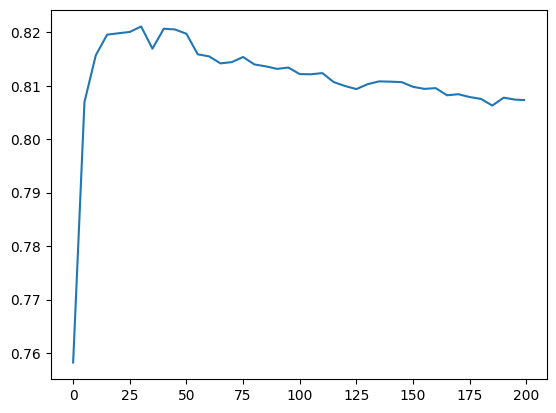

In [82]:
def parse_xgb_output():

    no_itrs = []
    train_score = []
    val_score = []

    for i in table.stdout.strip().split('\n'):

        no_itr, train_auc, val_auc = i.split('\t')

        no_itr = int(no_itr.strip('[]'))
        train_auc = float(train_auc.split(':')[1])
        val_auc = float(val_auc.split(':')[1])

        no_itrs.append(no_itr)
        train_score.append(train_auc)
        val_score.append(val_auc)

    dicts = {'iter':no_itrs, 'train_score':train_score, 'val_score':val_score}
    output = pd.DataFrame(dicts)
    return output

output = parse_xgb_output()
    
plt.plot(output.iter, output.val_score)

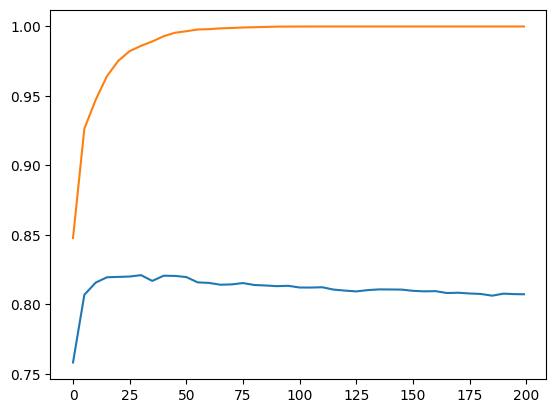

In [83]:
plt.plot(output.iter, output.val_score)
plt.plot(output.iter, output.train_score)

In [84]:
scores = {}

In [85]:
%%capture table
watchlist = [(dtrain,'train'), (dval, 'validation')]


x_params = {
    'eta': 0.9,
    'max_depth':6,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'auc',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 200)

In [86]:
key = 'eta = %s' %(x_params['eta'])
scores[key] = parse_xgb_output()

In [87]:
scores.keys()

dict_keys(['eta = 0.9'])

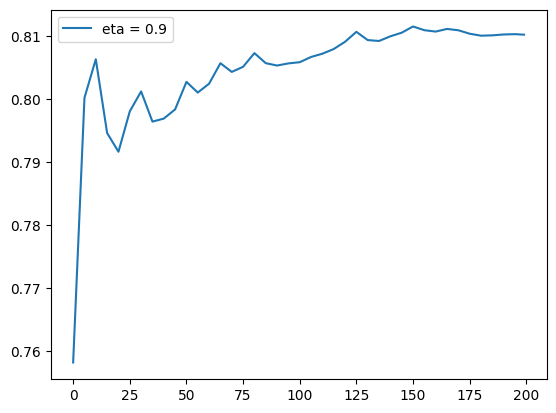

In [88]:
for key, value in scores.items():
    plt.plot(value.iter, value.val_score, label = key)

plt.legend()

In [89]:
scores = {}

In [90]:
%%capture table
watchlist = [(dtrain,'train'), (dval, 'validation')]


x_params = {
    'eta': 0.1,
    'max_depth':9,
    'min_child_weight':1,

    'objective':'binary:logistic',
    'eval_metric' : 'auc',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 200)

In [91]:
key = 'depth = %s' %(x_params['max_depth'])
scores[key] = parse_xgb_output()

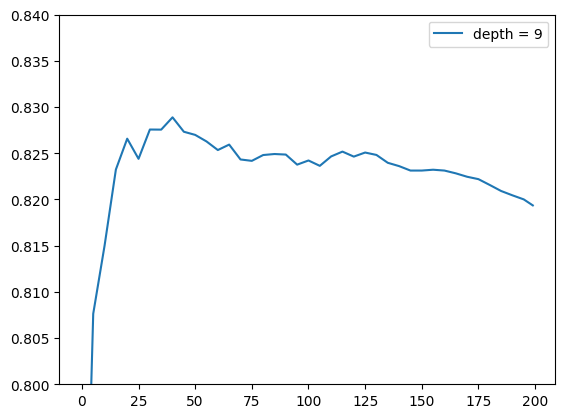

In [92]:
for key, value in scores.items():
    plt.plot(value.iter, value.val_score, label = key)

plt.ylim(0.8, 0.84)
plt.legend()

In [93]:
scores = {}

In [94]:
%%capture table
watchlist = [(dtrain,'train'), (dval, 'validation')]


x_params = {
    'eta': 0.1,
    'max_depth':3,
    'min_child_weight':30,

    'objective':'binary:logistic',
    'eval_metric' : 'auc',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,evals = watchlist, verbose_eval = 5,num_boost_round = 200)

In [95]:
key = 'weight = %s' %(x_params['min_child_weight'])
scores[key] = parse_xgb_output()

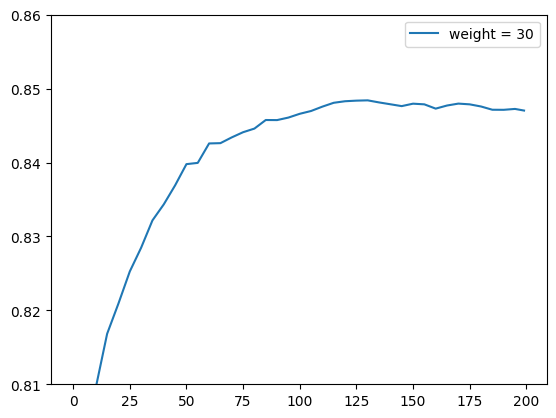

In [96]:
for key, value in scores.items():
    plt.plot(value.iter, value.val_score, label = key)

plt.ylim(0.81, 0.86)
plt.legend()

In [5]:
x_params = {
    'eta': 0.1,
    'max_depth':3,
    'min_child_weight':30,

    'objective':'binary:logistic',
    'eval_metric' : 'auc',
    
    'n_threads':8,
    'seed':1,
    'verbosity':0
}

model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 125)

In [6]:
pred = model.predict(dval)
auc = roc_auc_score(y_val,pred)
print(auc)

NameError: name 'dval' is not defined

In [7]:
full_data = pd.concat([full_train_df, full_val_df])
full_data = full_data.reset_index(drop = True)

full_y_train = (full_data['status'] == 'default').astype('int')
full_x_train = dv.transform(full_data[cat_col + num_col].to_dict(orient = 'records'))

dtrain = xgb.DMatrix(full_x_train, label = full_y_train)
test =  xgb.DMatrix(X_test)

model = xgb.train(x_params, dtrain = dtrain,num_boost_round = 125)
prediction = model.predict(test)
auc = roc_auc_score(y_test, prediction)
auc

0.8426050992720449

In [8]:
import bentoml
bentoml.xgboost.save_model('credict_risk', model, custom_objects={'dictvectorizer':dv})

Model(tag="credict_risk:ekvvbesogogeacar", path="C:\Users\Godwin\bentoml\models\credict_risk\ekvvbesogogeacar\")

In [68]:
dv.transform(data).round()

array([[3.70e+01, 4.50e+02, 2.00e+03, 0.00e+00, 6.00e+01, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.25e+02, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.49e+03, 1.00e+00, 0.00e+00, 2.00e+00,
        3.60e+01]])